# Proyecto de detección de anomalías  v7

- Red Neuronal Convolucional que implementa procesamiento de imagenes usando tomografías de pecho para detectar síntomas de neumonía y tumores pulmonares. Esta versión del proyecto utiliza Transfer Learning, es decir, usa un modelo previamente entrenado (ResNet 34).

> Este repositorio no incluye el data set, pues es muy pesado. Aqui puedes encontrar el [dataset completo de radiografías](https://drive.google.com/drive/u/2/folders/1FpSvkSt2oqENdJPizx_UeRBoI96cCpZf), descargalo y agregalo al folder. (Este enlace te llevará a una carpeta de google drive llamada fullDS, esta es la carpeta que posee todos los archivos necesarios para el proyecto final. El resto de las veriones corre con un data set de dos categorías llamado [chest_xray](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia))


Importaciones necesarias para el modelo:

In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models
import matplotlib.pyplot as plt

Solo para uso local: Para version en linea consultar [version en Google Colab](https://colab.research.google.com/drive/1TMxilf7aGYscBzrok5_2o1YJ48uu8rPO?authuser=2).

In [22]:
switch = int(input('Are you in the Mac or in the PC? Use 1 to indicate you are using Mac', ))

if switch == 1:
    
    trainPath = '/Users/fervargas/Developer/py/cnn/fullDS/train'
    testPath = '/Users/fervargas/Developer/py/cnn/fullDS/test'
    ValidationPath = '/Users/fervargas/Developer/py/cnn/fullDS/val' 
else:
    trainPath = "C:/Users/ferva/Developer/pulmonAID/chest_xray/train"
    testPath = "C:/Users/ferva/Developer/pulmonAID/chest_xray/test"
    ValidationPath = "C:/Users/ferva/Developer/pulmonAID/chest_xray/val"
transform = T.Compose([
        T.Resize([224,224]),
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

In [23]:
# Crear data sets para los entrenamientos, la validacion y las pruebas
trainDS = datasets.ImageFolder(trainPath, transform=transform)
valDS = datasets.ImageFolder(ValidationPath, transform=transform)
testDS = datasets.ImageFolder(testPath, transform=transform)

In [24]:
batchSize = 64

trainLoader = DataLoader(dataset=trainDS, batch_size=batchSize, shuffle=True)
valLoader = DataLoader(dataset=valDS, batch_size=batchSize, shuffle=True)
testLoader = DataLoader(dataset=testDS, batch_size=batchSize, shuffle=True)

In [25]:
for i, (x, y) in enumerate(valLoader):
    print(i, x.shape, y.shape)

0 torch.Size([39, 3, 224, 224]) torch.Size([39])


In [26]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


La imagen representa: NORMAL


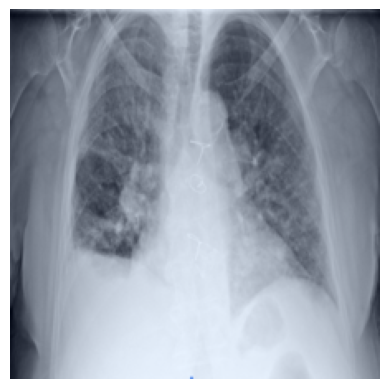

In [27]:
categorias = ['NORMAL', 'PNEUMONIA', 'COVID']

def plot_image(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

sample_id = np.random.randint(int(len(testLoader)))
print(f'La imagen representa: {categorias[testLoader.dataset[sample_id][1]]}')
image = testLoader.dataset[sample_id][0]
image = (image - image.min()) / (image.max() - image.min())
plot_image(image)

In [28]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
        return float(num_correct)/num_total   


In [29]:
model_resnet34 = models.resnet34()

In [30]:
model_aux = nn.Sequential(*list(model_resnet34.children()))

In [31]:
model_aux = nn.Sequential(*list(model_resnet34.children())[:-1])

In [32]:
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = True
    print(i, parameter.requires_grad)

0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True
14 True
15 True
16 True
17 True
18 True
19 True
20 True
21 True
22 True
23 True
24 True
25 True
26 True
27 True
28 True
29 True
30 True
31 True
32 True
33 True
34 True
35 True
36 True
37 True
38 True
39 True
40 True
41 True
42 True
43 True
44 True
45 True
46 True
47 True
48 True
49 True
50 True
51 True
52 True
53 True
54 True
55 True
56 True
57 True
58 True
59 True
60 True
61 True
62 True
63 True
64 True
65 True
66 True
67 True
68 True
69 True
70 True
71 True
72 True
73 True
74 True
75 True
76 True
77 True
78 True
79 True
80 True
81 True
82 True
83 True
84 True
85 True
86 True
87 True
88 True
89 True
90 True
91 True
92 True
93 True
94 True
95 True
96 True
97 True
98 True
99 True
100 True
101 True
102 True
103 True
104 True
105 True
106 True
107 True


In [33]:
def train(model, optimiser, epochs=100):
#     def train(model, optimiser, scheduler = None, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(trainLoader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input= scores, target=yi)
        
            optimiser.zero_grad()           
            cost.backward()
            optimiser.step()           
            
        acc = accuracy(model, valLoader)
#         if epoch%5 == 0:     
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')
#         scheduler.step()

In [34]:
hidden1 = 256 
hidden = 256
lr = 1e-4
epochs = 5

model1 = nn.Sequential(model_aux,
                       nn.Flatten(), 
                       nn.Linear(in_features=512, out_features= 3, bias= True))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

# train(model1, optimiser, epochs)

In [ ]:
train(model1, optimiser, epochs)
accuracy(model1, testLoader)

In [36]:
def getIndex(lista):
  result = lista.index(max(lista))
  return result

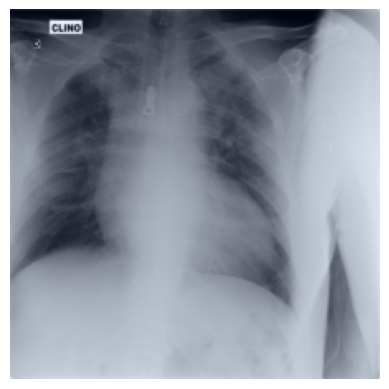

 Esta imagen representa: COVID


In [39]:
# Prediccion post-entrenamiento de COVID, PNEUMONIA y pulmones sanos (NORMAL)

model = model1.to(device=device)
sample_id = np.random.randint(int(len(testLoader)))
image = testLoader.dataset[sample_id][0]
image = (image - image.min()) / (image.max() - image.min())
plot_image(image)
nScores = model(image.to(device=device).unsqueeze(0))
scoreArray = nScores.tolist()
print(f' Esta imagen representa: {categorias[getIndex(scoreArray[0])]}')
#print(f'La imagen representa: {categorias[testLoader.dataset[sample_id][1]]}')